In [ ]:
#| default_exp HySpecNet11k_inference

# HySpecNet-11k: A Large-Scale Hyperspectral Dataset for Benchmarking Learning-Based Hyperspectral Image Compression Methods

- The **HySpecNet-11k dataset** is developed by:
  - The **Remote Sensing Image Analysis (RSiM)** group at TU Berlin.
  - The **Big Data Analytics in Earth Observation** group at the Berlin Institute for the Foundations of Learning and Data (BIFOLD).

- **Dataset Overview**:
  - HySpecNet-11k is a **large-scale hyperspectral benchmark dataset** containing 11,483 non-overlapping image patches.
  - Each patch consists of:
    - Dimensions: **128 × 128 pixels**.
    - Spectral Bands: **224 bands**.
    - Ground Sample Distance (GSD): **30 m**.

- **References**:
  - i. Github Repository: https://git.tu-berlin.de/rsim/hsi-compression.git
  - ii. Research Paper: https://arxiv.org/abs/2306.00385
  - iii. Dataset Link: https://datadryad.org/stash/dataset/doi:10.5061/dryad.fttdz08zh


In [ ]:
#| hide
from nbdev.showdoc import *

### 1. Environment Setup

- Python 3.10+
- NVIDIA GPU + CUDA
- Ubuntu 22.04 LTS (Recommended)

### 2. Dependencies

All dependencies are listed in the requirements.txt and can be installed via the following command:

`pip install -r requirements.txt`

### 3. Data Preparation

# Dataset Preparation Guide

- **Dataset Download**:
   - Download the dataset from the link mentioned in the description or directly from [Dataset](https://datadryad.org/stash/dataset/doi:10.5061/dryad.fttdz08zh).

- **File Renaming for Simplified Operations**:
   - To streamline operations and simplify tracking, the filenames in the patches directory are renamed to shorter, more concise names. This helps make Python scripting and dataset management easier.

- **Preprocessed NumPy Files**:
   - The preprocessed hyperspectral data for each patch is stored in NumPy format (`*-DATA.npy`). To generate the preprocessed NumPy files, run the `tif_to_npy.ipynb` notebook from the [HySpecNet Tools](https://git.tu-berlin.de/rsim/hyspecnet-tools).

- **Band Reduction**:
   - The original 224 spectral bands are reduced to 202 bands.
   - Bands **[127–141]** and **[161–167]** are removed due to strong water vapor absorption effects.

- **Data Normalization**:
   - The data is **clipped and rescaled** to the range [0–1] using **min-max normalization**.

- **Data Type Conversion**:
   - The rescaled data is converted to **float32** for efficient storage and processing.

### Updated Dataset Structure:
The updated datasets directory structure is shown below:

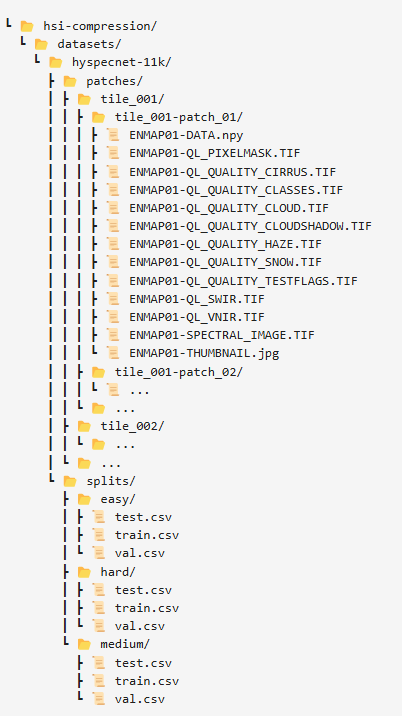




### 4. Model Architecture

The proposed model leverages a **Convolutional Autoencoder (CAE)** for hyperspectral image compression, aiming to reduce the dimensionality while retaining essential spatial and spectral information. The CAE consists of an **encoder** and a **decoder**, where the encoder extracts features through a series of convolutional operations, compressing the input data into a lower-dimensional latent space. The decoder reconstructs the original image using transposed convolution layers, aiming to closely match the input image. The model is trained using a reconstruction loss, specifically the **Mean Squared Error (MSE)**, which minimizes the difference between the input and reconstructed images.

### Key Performance Indicators (KPIs):
- **Compression Efficiency**: Significant reduction in data size while preserving image quality.
- **Reconstruction Quality**: High fidelity of reconstructed images, measured by metrics like PSNR (Peak Signal-to-Noise Ratio).
- **Spatial-Spectral Preservation**: Effective retention of both spatial and spectral features.
- **Scalability**: Capability to handle large-scale hyperspectral datasets.

For further details, refer to the [Research Paper](https://isprs-archives.copernicus.org/articles/XLIII-B1-2021/15/2021/isprs-archives-XLIII-B1-2021-15-2021.pdf).


In [ ]:
#| eval:false
#|export

import math
import torch.nn.functional as f

from torch import nn


def cae1d(src_channels=202):
    return ConvolutionalAutoencoder1D(src_channels=src_channels)


def cae1d_8bpppc(src_channels=202):
    return ConvolutionalAutoencoder1D(src_channels=src_channels)


class ConvolutionalAutoencoder1D(nn.Module):
    """
    Title:
        1D-CONVOLUTIONAL AUTOENCODER BASED HYPERSPECTRAL DATA COMPRESSION
    Authors:
        Kuester, Jannick and Gross, Wolfgang and Middelmann, Wolfgang
    Paper:
        https://doi.org/10.5194/isprs-archives-XLIII-B1-2021-15-2021
    Cite:
        @article{kuester20211d,
            title={1D-convolutional autoencoder based hyperspectral data compression},
            author={Kuester, Jannick and Gross, Wolfgang and Middelmann, Wolfgang},
            journal={International Archives of Photogrammetry, Remote Sensing and Spatial Information Sciences},
            volume={43},
            pages={15--21},
            year={2021},
            publisher={Copernicus GmbH}
        }
    """

    def __init__(self, src_channels=202):
        super(ConvolutionalAutoencoder1D, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=64,
                kernel_size=11,
                stride=1,
                padding="same",
            ),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(
                in_channels=64,
                out_channels=32,
                kernel_size=11,
                stride=1,
                padding="same",
            ),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(
                in_channels=32,
                out_channels=16,
                kernel_size=9,
                stride=1,
                padding="same",
            ),
            nn.LeakyReLU(),
            nn.Conv1d(
                in_channels=16,
                out_channels=1,
                kernel_size=7,
                stride=1,
                padding="same",
            ),
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=16,
                kernel_size=7,
                stride=1,
                padding="same",
            ),
            nn.LeakyReLU(),
            nn.Conv1d(
                in_channels=16,
                out_channels=32,
                kernel_size=9,
                stride=1,
                padding="same",
            ),
            nn.LeakyReLU(),
            nn.Upsample(
                scale_factor=2
            ),
            nn.Conv1d(
                in_channels=32,
                out_channels=64,
                kernel_size=11,
                stride=1,
                padding="same",
            ),
            nn.LeakyReLU(),
            nn.Upsample(
                scale_factor=2
            ),
            nn.Conv1d(
                in_channels=64,
                out_channels=1,
                kernel_size=11,
                stride=1,
                padding="same",
            ),
            nn.Sigmoid()
        )

        self.src_channels = src_channels

        self.spectral_downsamplings = 2
        self.spectral_downsampling_factor_estimated = 2 ** self.spectral_downsamplings

        self.spatial_downsamplings = 0
        self.spatial_downsampling_factor = 2 ** self.spatial_downsamplings

        self.latent_channels = int(math.ceil(self.src_channels / 2 ** self.spectral_downsamplings))
        self.spectral_downsampling_factor = self.src_channels / self.latent_channels
        self.compression_ratio = self.spectral_downsampling_factor * self.spatial_downsampling_factor ** 2
        self.bpppc = 32.0 / self.compression_ratio

        self.padding_amount = 0 if self.src_channels % self.spectral_downsampling_factor_estimated == 0 \
            else self.spectral_downsampling_factor_estimated - self.src_channels % self.spectral_downsampling_factor_estimated

    def forward(self, x):
        n, c, h, w = x.shape

        x = x.permute(0, 2, 3, 1).reshape(-1, c)
        if self.padding_amount > 0:
            x = f.pad(x, (self.padding_amount, 0))
        x = x.unsqueeze(1)

        y = self.encoder(x)
        x_hat = self.decoder(y)

        if self.padding_amount > 0:
            x_hat = x_hat[:, :, self.padding_amount:]
        x_hat = x_hat.squeeze(1)
        x_hat = x_hat.reshape(n, h, w, c).permute(0, 3, 1, 2)

        return x_hat

    def compress(self, x):
        n, c, h, w = x.shape
        
        x = x.permute(0, 2, 3, 1).reshape(-1, c)
        if self.padding_amount > 0:
            x = f.pad(x, (self.padding_amount, 0))
        x = x.unsqueeze(1)
        
        y = self.encoder(x)
        y = y.squeeze(1)
        y = y.reshape(n, h, w, -1).permute(0, 3, 1, 2)

        return y

    def decompress(self, y):
        n, c, h, w = y.shape

        y = y.permute(0, 2, 3, 1).reshape(-1, c)
        y = y.unsqueeze(1)
        x_hat = self.decoder(y)

        if self.padding_amount > 0:
            x_hat = x_hat[:, :, self.padding_amount:]
        x_hat = x_hat.squeeze(1)
        x_hat = x_hat.reshape(n, h, w, -1).permute(0, 3, 1, 2)

        return x_hat

    @classmethod
    def from_state_dict(cls, state_dict):
        net = cls()
        net.load_state_dict(state_dict)
        return net


if __name__ == '__main__':
    import torch
    import torchsummary

    model = ConvolutionalAutoencoder1D()
    print(model)

    torchsummary.summary(model, input_size=(202, 128, 128), batch_size=2, device='cpu')

    in_tensor = torch.randn(1, 202, 128, 128)
    print("in shape:\t\t", in_tensor.shape)

    latent_tensor = model.compress(in_tensor)
    print("latent shape:\t\t", latent_tensor.shape)
    
    out_tensor = model(in_tensor)
    print("out shape:\t\t", out_tensor.shape)

    print("in shape = out shape:\t", out_tensor.shape == in_tensor.shape)

    print("real bpppc:\t\t", 32 * torch.numel(latent_tensor) / torch.numel(in_tensor))
    print("model parameter bpppc:\t", model.bpppc)


ConvolutionalAutoencoder1D(
  (encoder): Sequential(
    (0): Conv1d(1, 64, kernel_size=(11,), stride=(1,), padding=same)
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 32, kernel_size=(11,), stride=(1,), padding=same)
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(32, 16, kernel_size=(9,), stride=(1,), padding=same)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv1d(16, 1, kernel_size=(7,), stride=(1,), padding=same)
    (9): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=same)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(16, 32, kernel_size=(9,), stride=(1,), padding=same)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Upsample(scale_factor=2.0, mode='nearest')
    (5): Conv1d(32, 64, kernel_size=(11,), st

### 5. Data Visualization HySpecNet11k

In [ ]:
#| eval:false
#| export
import os
import random
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from IPython.display import Image, display

# Configure matplotlib for headless environments
import matplotlib
matplotlib.use('Agg')

# Define the base directory (update if needed)
BASE_DIR = "/root/HSI_HypSpecNet11k/hsi-compression/datasets/hyspecnet-11k/patches"

#|export
# Helper function to check if the image is mostly blank
def is_mostly_blank(image):
    """
    Checks if the image has less than 5% non-zero pixels.

    Args:
        image (np.ndarray): The image array.

    Returns:
        bool: True if the image is mostly blank, otherwise False.
    """
    non_zero_count = np.count_nonzero(image)
    total_count = image.size
    return (non_zero_count / total_count) < 0.05

#|export
# Helper function to enhance the image using contrast stretching
def enhance_image(image):
    """
    Enhances the image using contrast stretching.

    Args:
        image (np.ndarray): The image array.

    Returns:
        np.ndarray: The enhanced image array.
    """
    p2, p98 = np.nanpercentile(image, (2, 98))
    img_stretched = np.clip((image - p2) / (p98 - p2), 0, 1)
    img_stretched = np.nan_to_num(img_stretched, nan=0)
    return img_stretched

#|export
# Function to collect valid .tif files
def collect_tif_files(base_dir=BASE_DIR):
    """
    Collects all valid .tif files from the specified base directory.

    Args:
        base_dir (str): The base directory to search for .tif files.

    Returns:
        list: List of valid .tif file paths.
    """
    tif_files = []
    print("Collecting .tif files...")
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(".tif") or file.lower().endswith(".tiff"):
                if "QL" in file.upper() or "MASK" in file.upper() or "HAZE" in file.upper():
                    continue
                tif_files.append(os.path.join(root, file))
    return tif_files

#|export
# Function to process and display random .tif files
def process_and_display_images(tif_files, num_samples=5):
    """
    Processes and displays random samples of .tif files.

    Args:
        tif_files (list): List of .tif file paths.
        num_samples (int): Number of random samples to process.
    """
    if len(tif_files) < num_samples:
        print("Not enough .tif files found. Displaying all available files.")
        selected_files = tif_files
    else:
        selected_files = random.sample(tif_files, num_samples)

    for file_path in selected_files:
        print(f"Processing file: {file_path}")

        try:
            with rasterio.open(file_path) as src:
                img = src.read()
                no_data_value = src.nodata

                # Replace no-data values with NaN
                if no_data_value is not None:
                    img = np.where(img == no_data_value, np.nan, img)

                # Skip mostly blank images
                if is_mostly_blank(img):
                    print(f"Skipping mostly blank image: {file_path}")
                    continue

                num_bands = img.shape[0]
                print(f"Number of bands in image: {num_bands}")

                # Select 5 unique bands to display
                if num_bands < 5:
                    selected_bands = list(range(num_bands))
                else:
                    selected_bands = random.sample(range(num_bands), 5)

                # Plot and save the selected bands
                fig, axes = plt.subplots(2, 3, figsize=(10, 5))
                for i, band in enumerate(selected_bands):
                    img_enhanced = enhance_image(img[band])
                    ax = axes.flatten()[i]

                    ax.imshow(img_enhanced, cmap='gray')
                    ax.set_title(f"Band {band + 1}")  # Removed image name from title
                    ax.axis('off')

                plt.tight_layout()

                # Save the figure as an image file
                output_path = f"{os.path.splitext(file_path)[0]}_preview.png"
                plt.savefig(output_path)
                plt.close(fig)
                print(f"Preview saved as: {output_path}")

                # Display the saved image in the notebook
                display(Image(output_path))

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")


#|export
# Main function to execute the workflow
def main():
    """
    Main function to collect, process, and display images.
    """
    tif_files = collect_tif_files()
    process_and_display_images(tif_files, num_samples=1)


Processing file: /root/HSI_HypSpecNet11k/hsi-compression/datasets/hyspecnet-11k/patches/tile_015/tile_015-patch_24/ENMAP01-____L2A-DT0000004990_20221104T023040Z_003_V010110_20221116T153520Z-Y05340661_X04130540-SPECTRAL_IMAGE.TIF
Number of bands in image: 224


/root/miniconda3/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1424: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Preview saved as: /root/HSI_HypSpecNet11k/hsi-compression/datasets/hyspecnet-11k/patches/tile_015/tile_015-patch_24/ENMAP01-____L2A-DT0000004990_20221104T023040Z_003_V010110_20221116T153520Z-Y05340661_X04130540-SPECTRAL_IMAGE_preview.png


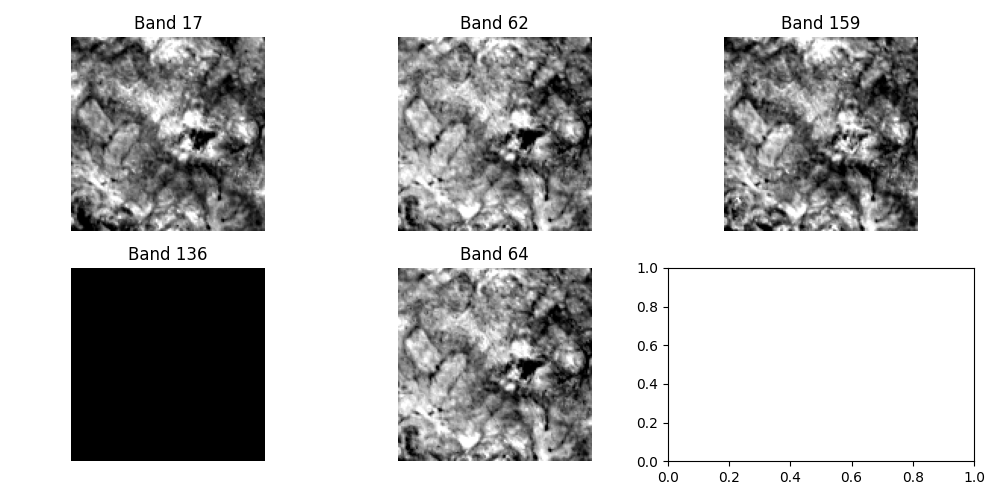

In [ ]:
#| eval:false
# Function to call 
main()

### 6. Test Run

The ``test.py`` expects the following command line arguments:

**Command-Line Arguments for `test.py`**:

| **Parameter**    | **Description**                              | **Default**                   |
|------------------|----------------------------------------------|-------------------------------|
| `--device`       | Device to use (default: 0), e.g., `cpu` or `0` | `0`                           |
| `--batch-size`   | Test batch size                              | `64`                          |
| `-n`             | Data loader threads                          | `0`                           |
| `-d`             | Path to dataset                              | `./datasets/hyspecnet-11k/`   |
| `--mode`         | Dataset split difficulty                     | `easy`                        |
| `-m`             | Model architecture                           | `cae1d`                       |
| `--checkpoint`   | Path to the checkpoint to evaluate           | `None`                        |
| `--half`         | Convert model to half floating point (fp16)  | `False`                       |
| `--save-dir`     | Directory to save results                    | `./results/tests/`            |
| `--seed`         | Set random seed for reproducibility          | `10587`                       |


**Note:** Customize the batch-size as per your system specification

**Pre-Trained Weights**

Pre-trained weights are publicly available and should be downloaded into the `./results/weights/` folder.

| **Method**    | **Model**  | **Rate**   | **PSNR**   | **Download Link**                                                                                      |
|---------------|------------|------------|------------|--------------------------------------------------------------------------------------------------------|
| 1D-CAE [1]    | `cae1d`    | 8.08 bpppc | 54.85 dB   | [cae1d_8bpppc.pth.tar](https://tubcloud.tu-berlin.de/s/GpmXDAWEeo2nG5w/download/cae1d_8bpppc.pth.tar)   |

**Reference**:
- [1] [1D-Convolutional Autoencoder (1D-CAE)](https://doi.org/10.5194/isprs-archives-XLIII-B1-2021-15-2021)




**Steps to run the test.sh**

Specify the parameters in the `test.sh` file and then execute the following command

- Display the content of `test.sh` using:
  `cat test.sh`

- Make the `test.sh` file executable:
  `chmod +x test.sh`

- Run the script:
  `./test.sh`

Or run the python code directly through the console:

```bash
python test.py \
    --device 0 \
    --batch-size 64 \
    --num-workers 4 \
    --mode easy \
    --model cae1d \
    --checkpoint ./results/weights/cae1d_8bpppc.pth.tar



In [ ]:
#| eval: False

os.chdir("/root/HSI_HypSpecNet11k/hsi-compression")
!bash test.sh

nohup: ignoring input and redirecting stderr to stdout
Loading ./results/weights/cae1d_8bpppc.pth.tar
/root/HSI_HypSpecNet11k/hsi-compression/utils/checkpoint.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues re

### 7. Result

In [ ]:
#| eval:false
#| export
import json
import os

def analyze_results(json_file="/root/HSI_HypSpecNet11k/hsi-compression/results/tests/weights.json"):
    """
    Analyzes the compression results from a given JSON file and prints key metrics.

    Args:
        json_file (str): Path to the JSON file containing the compression results.
    """
    if not os.path.exists(json_file):
        print(f"File not found: {json_file}")
        return

    with open(json_file, 'r') as f:
        data = json.load(f)

    # Extract values
    name = data.get("name", "N/A")
    description = data.get("description", "No description")
    bpppc = data["results"].get("bpppc", [None])[0]
    psnr = data["results"].get("psnr", [None])[0]
    ssim = data["results"].get("ssim", [None])[0]
    sa = data["results"].get("sa", [None])[0]
    encoding_time = data["results"].get("encoding_time", [None])[0]
    decoding_time = data["results"].get("decoding_time", [None])[0]

    # Print extracted values
    print(f"Name: {name}")
    print(f"Description: {description}")
    print(f"Bits Per Pixel Per Channel (bpppc): {bpppc:.2f}")
    print(f"PSNR: {psnr:.2f} dB")
    print(f"SSIM: {ssim:.4f}")
    if sa is not None:
        print(f"Spectral Angle (SA): {sa:.2f}")
    else:
        print("Spectral Angle (SA): Not available")

    print(f"Encoding Time: {encoding_time:.4f} seconds")
    print(f"Decoding Time: {decoding_time:.4f} seconds")

    # Inference Analysis
    if psnr > 40 and ssim > 0.95:
        print("Inference: The compression maintains high image quality.")
    else:
        print("Inference: The compression may have degraded image quality.")

    if encoding_time < 0.01:
        print("Inference: The encoding process is fast.")
    else:
        print("Inference: The encoding process is relatively slow.")

    if decoding_time < 0.01:
        print("Inference: The decoding process is fast.")
    else:
        print("Inference: The decoding process is relatively slow.")



In [ ]:
#| eval:false
analyze_results()

Name: cae1d
Description: Test
Bits Per Pixel Per Channel (bpppc): 8.08
PSNR: 56.20 dB
SSIM: 0.9989
Spectral Angle (SA): 0.70
Encoding Time: 0.0058 seconds
Decoding Time: 0.0036 seconds
Inference: The compression maintains high image quality.
Inference: The encoding process is fast.
Inference: The decoding process is fast.


In [ ]:
#| export
def foo(): pass

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()